# Granger Causality with Google Trends - Did `itaewon class` cause `โคชูจัง`?

We will give an example of Granger casuality test with interests over time of `itaewon class` and `โคชูจัง` in Thailand during 2020-01 to 2020-04. During the time, gochujang went out of stock in many supermarkets supposedly because people micking the show. We are examining the hypothesis that the interst over time of `itaewon class` Granger causes that of `โคชูจัง`.

$x_t$ Granger causes $y_t$ means that the past values of $x_t$ could contain information that is useful in predicting $y_t$.

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import warnings
warnings.filterwarnings('ignore')
import matplotlib
matplotlib.rc('font', family='Ayuthaya') # MacOS

## 1. Get Trend Objects with Thailand Offset

We can get interest over time of a keyword with the unofficial `pytrends` library.

In [64]:
from pytrends.request import TrendReq

#get trend objects with thailand offset 7*60 = 420 minutes
trend = TrendReq(hl='th-TH', tz=420)

In [65]:
#compare 2 keywords
kw_list = ['โคชูจัง','itaewon class']
trend.build_payload(kw_list, geo='TH',timeframe='2020-01-01 2020-04-30')
df = trend.interest_over_time().iloc[:,:2]
df.head()

,โคชูจัง,itaewon class
date,,
2020-01-01,2,0
2020-01-02,1,0
2020-01-03,1,0
2020-01-04,1,0
2020-01-05,1,0


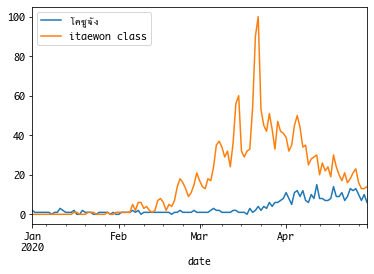

In [66]:
df.plot()

## 2. Stationarity Check: Augmented Dickey-Fuller Test

Stationarity is a pre-requisite for Granger causality test. We first use [augmented Dickey-Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) to detect stationarity. For the following model:

$$\Delta y_t = \alpha + \beta t + \gamma y_{t-1} + \delta_1 \Delta y_{t-1} + \cdots + \delta_{p-1} \Delta y_{t-p+1} + \varepsilon_t$$

where $\alpha$  is a constant, $\beta$ the coefficient on a time trend and $p$ the lag order of the autoregressive process. The null hypothesis is that $\gamma$ is 0; that is, $y_{t-1}$ does not have any valuable contribution to predicting $y_t$. If we reject the null hypothesis, that means $y_t$ does not have a unit root.

In [67]:
from statsmodels.tsa.stattools import adfuller

#test for stationarity with augmented dickey fuller test
def unit_root(name,series):
    signif=0.05
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0],4),'pvalue':round(r[1],4),'n_lags':round(r[2],4),'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val,lenght=6): 
        return str(val).ljust(lenght)
    print(f'Augmented Dickey-Fuller Test on "{name}"')
    print('-'*47)
    print(f'Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f'Observation           = {output["n_obs"]}')
    print(f'Significance Level    = {signif}')
    print(f'Test Statistic        = {output["test_statistic"]}')
    print(f'No. Lags Chosen       = {output["n_lags"]}')
    for key,val in r[4].items():
        print(f'Critical value {adjust(key)} = {round(val,3)}')
    if p_value <= signif:
        print(f'=> P-Value = {p_value}. Rejecting null hypothesis.')
        print(f'=> Series is stationary.')
    else:
        print(f'=> P-Value = {p_value}. Cannot reject the null hypothesis.')
        print(f'=> "{name}" is non-stationary.')

2.1. `โคชูจัง` unit root test

In [68]:
name = 'โคชูจัง'
series = df.iloc[:,0]
unit_root(name,series)

Augmented Dickey-Fuller Test on "โคชูจัง"
-----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Observation           = 107
Significance Level    = 0.05
Test Statistic        = -0.4375
No. Lags Chosen       = 13
Critical value 1%     = -3.493
Critical value 5%     = -2.889
Critical value 10%    = -2.581
=> P-Value = 0.9036. Cannot reject the null hypothesis.
=> "โคชูจัง" is non-stationary.


2.2. `itaewon class` unit root test

In [69]:
name = 'itaewon class'
series = df.iloc[:,1]
unit_root(name,series)

Augmented Dickey-Fuller Test on "itaewon class"
-----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Observation           = 113
Significance Level    = 0.05
Test Statistic        = -1.3504
No. Lags Chosen       = 7
Critical value 1%     = -3.49
Critical value 5%     = -2.887
Critical value 10%    = -2.581
=> P-Value = 0.6058. Cannot reject the null hypothesis.
=> "itaewon class" is non-stationary.


We could not reject the null hypothesis of augmented Dickey-Fuller test for both time series. This should be evident just by looking at the plot that they are not stationary (have stable same means, variances, autocorrelations over time).

## 3. Taking 1st Difference

Most commonly used methods to "stationarize" a time series is to take the first difference aka $\frac{y_t-y_{t-1}}{y_{t-1}}$ of the time series.

In [70]:
diff_df = df.diff(1).dropna()

3.1. 1st Difference of `โคชูจัง` unit root test

In [71]:
name = 'โคชูจัง'
series = diff_df.iloc[:,0]
unit_root(name,series)

Augmented Dickey-Fuller Test on "โคชูจัง"
-----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Observation           = 107
Significance Level    = 0.05
Test Statistic        = -2.8133
No. Lags Chosen       = 12
Critical value 1%     = -3.493
Critical value 5%     = -2.889
Critical value 10%    = -2.581
=> P-Value = 0.0564. Cannot reject the null hypothesis.
=> "โคชูจัง" is non-stationary.


3.2. 1st Difference of `itaewon class` unit root test

In [72]:
name = 'itaewon class'
series = diff_df.iloc[:,1]
unit_root(name,series)

Augmented Dickey-Fuller Test on "itaewon class"
-----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Observation           = 113
Significance Level    = 0.05
Test Statistic        = -4.5131
No. Lags Chosen       = 6
Critical value 1%     = -3.49
Critical value 5%     = -2.887
Critical value 10%    = -2.581
=> P-Value = 0.0002. Rejecting null hypothesis.
=> Series is stationary.


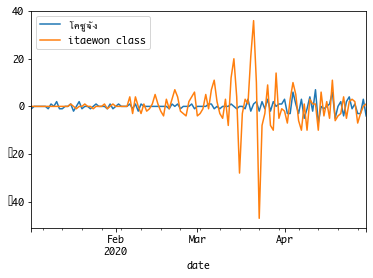

In [73]:
diff_df.plot()

- 1st Difference of `itaewon class` is stationary at 5% significance.
- 1st Difference of `โคชูจัง` is not stationary but 0.0564 is close enough to 5% significance, we are making an exception for this example.

## 5. Find Lag Length

Note that `maxlag` is an important hyperparameter that determines if your Granger test is significant or not. There are some criteria you can you to find that lag but as with any frequentist statistical test, you need to understand what assumptions you are making.

In [74]:
import statsmodels.tsa.api as smt
df_test = diff_df.copy()
df_test.head()

,โคชูจัง,itaewon class
date,,
2020-01-02,-1.0,0.0
2020-01-03,0.0,0.0
2020-01-04,0.0,0.0
2020-01-05,0.0,0.0
2020-01-06,0.0,0.0


In [75]:
# make a VAR model
model = smt.VAR(df_test)
res = model.select_order(maxlags=None)
print(res.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        5.692       5.742       296.4       5.712
1        5.505       5.655       245.9       5.566
2        5.360       5.610       212.8       5.461
3        5.350       5.700       210.8       5.492
4        5.271       5.720       194.7       5.453
5        5.031      5.580*       153.3      5.254*
6        5.042       5.692       155.2       5.305
7        5.029       5.778       153.3       5.333
8        4.993       5.842       148.1       5.337
9        5.029       5.979       154.0       5.414
10       5.032       6.081       154.9       5.458
11      4.979*       6.128      147.3*       5.445
12       5.012       6.261       152.9       5.518
13       4.994       6.343       150.8       5.541
--------------------------------------------------


One thing to note is that this hyperparameter affects the conclusion of the test and the best solution is to have a strong theoretical assumption but if not the empirical methods above could be the next best thing.

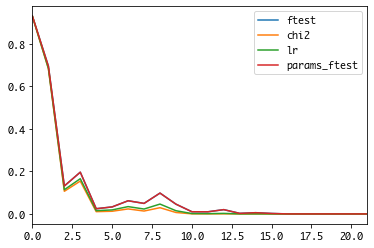

In [76]:
#find the optimal lag
lags = list(range(1,23))
res = grangercausalitytests(df_test, maxlag=lags, verbose=False)
p_values = []
for i in lags:
    p_values.append({'maxlag':i,
                    'ftest':res[i][0]['ssr_ftest'][1], 
                    'chi2':res[i][0]['ssr_chi2test'][1],
                    'lr':res[i][0]['lrtest'][1],
                    'params_ftest':res[i][0]['params_ftest'][1],})
p_df = pd.DataFrame(p_values)
p_df.iloc[:,1:].plot()

## 6. Granger Causality Test

The Granger causality test the null hypothesis that $x_t$ **DOES NOT** Granger cause $y_t$ with the following models:

$$y_{t}=a_{0}+a_{1}y_{t-1}+a_{2}y_{t-2}+\cdots +a_{m}y_{t-m}+{\text{error}}_{t}$$

and

$$y_{t}=a_{0}+a_{1}y_{t-1}+a_{2}y_{t-2}+\cdots +a_{m}y_{t-m}+b_{p}x_{t-p}+\cdots +b_{q}x_{t-q}+{\text{error}}_{t}$$

An F-statistic is then calculated by ratio of residual sums of squares of these two models.

In [38]:
from statsmodels.tsa.stattools import grangercausalitytests

def granger_causation_matrix(data, variables,test,verbose=False):
    x = pd.DataFrame(np.zeros((len(variables),len(variables))), columns=variables,index=variables)
    for c in x.columns:
        for r in x.index:
            test_result = grangercausalitytests(data[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: 
                print(f'Y = {r}, X= {c},P Values = {p_values}')
            min_p_value = np.min(p_values)
            x.loc[r,c] = min_p_value
    x.columns = [var + '_x' for var in variables]
    x.index = [var + '_y' for var in variables]
    return x

In [43]:
# maxlag is the maximum lag that is possible number by statsmodels default
nobs = len(df_test.index)
maxlag = round(12*(nobs/100.)**(1/4.))
maxlag

13

In [44]:
data = df_test
variables = df_test.columns

#### 6.1. SSR based F test

In [45]:
test = 'ssr_ftest'
ssr_ftest = granger_causation_matrix(data, variables, test)
ssr_ftest['test'] = 'ssr_ftest'

#### 6.2. SSR based chi2 test

In [46]:
test = 'ssr_chi2test'
ssr_chi2test = granger_causation_matrix(data, variables, test)
ssr_chi2test['test'] = 'ssr_chi2test'

#### 6.3. Likelihood ratio test

In [47]:
test = 'lrtest'
lrtest = granger_causation_matrix(data, variables, test)
lrtest['test'] = 'lrtest'

#### 6.4. Parameter F test

In [48]:
test = 'params_ftest'
params_ftest = granger_causation_matrix(data, variables, test)
params_ftest['test'] = 'params_ftest'

In [50]:
frames = [ssr_ftest, ssr_chi2test, lrtest, params_ftest]
all_test = pd.concat(frames)
all_test

,โคชูจัง_x,itaewon class_x,test
โคชูจัง_y,1.0000,0.0100,ssr_ftest
itaewon class_y,0.4093,1.0000,ssr_ftest
โคชูจัง_y,1.0000,0.0002,ssr_chi2test
itaewon class_y,0.3220,1.0000,ssr_chi2test
โคชูจัง_y,1.0000,0.0013,lrtest
itaewon class_y,0.3415,1.0000,lrtest
โคชูจัง_y,0.0000,0.0100,params_ftest
itaewon class_y,0.4093,0.0000,params_ftest


We may conclude that `itaewon class` Granger caused `โคชูจัง`, but `โคชูจัง`  did not Granger cause `itaewon class`.

# What About Chicken and Eggs?

We use the annual chicken and eggs data from [Thurman and Fisher (1988) hosted by UIUC](http://www.econ.uiuc.edu/~econ536/Data/).

## 1. Get data from csv file

In [77]:
#chicken and eggs
chickeggs = pd.read_csv('chickeggs.csv')
chickeggs

,year,chic,egg
0,1930,468491,3581
1,1931,449743,3532
2,1932,436815,3327
3,1933,444523,3255
4,1934,433937,3156
...,...,...,...
70,2000,434687,7060
71,2001,441089,7174
72,2002,438948,7271
73,2003,448748,7289


In [78]:
#normalize for 1930 to be 1
df = chickeggs.iloc[:,1:]
df['chic'] = df.chic /  df.chic[0]
df['egg'] = df.egg /  df.egg[0]

In [79]:
df = df[['chic','egg']]
df

,chic,egg
0,1.000000,1.000000
1,0.959982,0.986317
2,0.932387,0.929070
3,0.948840,0.908964
4,0.926244,0.881318
...,...,...
70,0.927845,1.971516
71,0.941510,2.003351
72,0.936940,2.030438
73,0.957858,2.035465


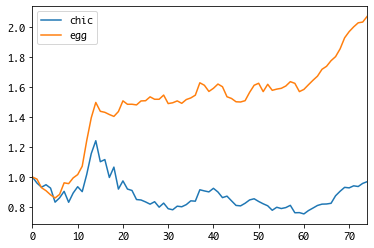

In [80]:
df.plot()

## 2. Stationarity check: Augmented Dickey-Fuller Test

2.1. `egg` unit root test

In [81]:
name = 'egg'
series = df.iloc[:,0]
unit_root(name,series)

Augmented Dickey-Fuller Test on "egg"
-----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Observation           = 70
Significance Level    = 0.05
Test Statistic        = -2.6729
No. Lags Chosen       = 4
Critical value 1%     = -3.527
Critical value 5%     = -2.904
Critical value 10%    = -2.589
=> P-Value = 0.0788. Cannot reject the null hypothesis.
=> "egg" is non-stationary.


2.2. `chic` unit root test

In [82]:
name = 'chic'
series = df.iloc[:,1]
unit_root(name,series)

Augmented Dickey-Fuller Test on "chic"
-----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Observation           = 73
Significance Level    = 0.05
Test Statistic        = -0.809
No. Lags Chosen       = 1
Critical value 1%     = -3.523
Critical value 5%     = -2.902
Critical value 10%    = -2.588
=> P-Value = 0.8165. Cannot reject the null hypothesis.
=> "chic" is non-stationary.


## 3. Taking 1st Difference

In [83]:
diff_df = df.diff(1).dropna()
diff_df

,chic,egg
1,-0.040018,-0.013683
2,-0.027595,-0.057247
3,0.016453,-0.020106
4,-0.022596,-0.027646
5,-0.093874,-0.020944
...,...,...
70,-0.003498,0.041329
71,0.013665,0.031835
72,-0.004570,0.027087
73,0.020918,0.005027


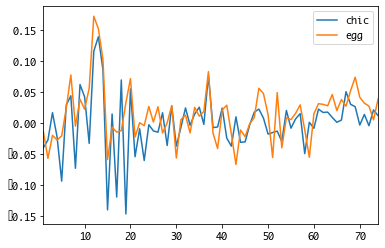

In [84]:
diff_df.plot()

3.1. 1st Difference of `egg` unit root test

In [85]:
name = 'egg'
series = diff_df.iloc[:,0]
unit_root(name,series)

Augmented Dickey-Fuller Test on "egg"
-----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Observation           = 71
Significance Level    = 0.05
Test Statistic        = -4.4793
No. Lags Chosen       = 2
Critical value 1%     = -3.526
Critical value 5%     = -2.903
Critical value 10%    = -2.589
=> P-Value = 0.0002. Rejecting null hypothesis.
=> Series is stationary.


3.2. 1st Difference of `chic` unit root test

In [86]:
name = 'chic'
series = diff_df.iloc[:,1]
unit_root(name,series)

Augmented Dickey-Fuller Test on "chic"
-----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Observation           = 73
Significance Level    = 0.05
Test Statistic        = -5.6382
No. Lags Chosen       = 0
Critical value 1%     = -3.523
Critical value 5%     = -2.902
Critical value 10%    = -2.588
=> P-Value = 0.0. Rejecting null hypothesis.
=> Series is stationary.


## 4. Find Lag Length

In [88]:
# make a VAR model
model = smt.VAR(diff_df)
res = model.select_order(maxlags=None)
print(res.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -12.85      -12.78   2.628e-06      -12.82
1      -13.11*     -12.90*  2.032e-06*     -13.03*
2       -13.04      -12.70   2.177e-06      -12.90
3       -13.00      -12.52   2.275e-06      -12.81
4       -12.99      -12.38   2.284e-06      -12.75
5       -13.03      -12.28   2.214e-06      -12.73
6       -12.95      -12.06   2.415e-06      -12.60
7       -12.83      -11.81   2.730e-06      -12.43
8       -12.83      -11.68   2.742e-06      -12.38
9       -12.75      -11.46   3.007e-06      -12.24
10      -12.89      -11.46   2.663e-06      -12.33
11      -12.89      -11.32   2.710e-06      -12.27
--------------------------------------------------


Eggs Granger cause Chickens


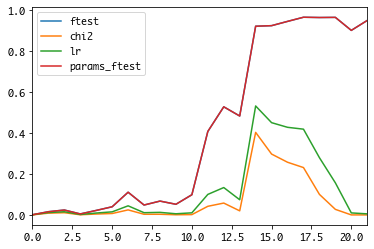

In [90]:
#find the optimal lag
lags = list(range(1,23))
res = grangercausalitytests(diff_df, maxlag=lags, verbose=False)
p_values = []
for i in lags:
    p_values.append({'maxlag':i,
                    'ftest':res[i][0]['ssr_ftest'][1], 
                    'chi2':res[i][0]['ssr_chi2test'][1],
                    'lr':res[i][0]['lrtest'][1],
                    'params_ftest':res[i][0]['params_ftest'][1],})
p_df = pd.DataFrame(p_values)
print('Eggs Granger cause Chickens')
p_df.iloc[:,1:].plot()

Chickens Granger cause Eggs


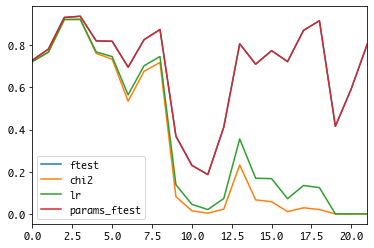

In [94]:
#find the optimal lag
lags = list(range(1,23))
res = grangercausalitytests(diff_df[['egg','chic']], maxlag=lags, verbose=False)
p_values = []
for i in lags:
    p_values.append({'maxlag':i,
                    'ftest':res[i][0]['ssr_ftest'][1], 
                    'chi2':res[i][0]['ssr_chi2test'][1],
                    'lr':res[i][0]['lrtest'][1],
                    'params_ftest':res[i][0]['params_ftest'][1],})
p_df = pd.DataFrame(p_values)
print('Chickens Granger cause Eggs')
p_df.iloc[:,1:].plot()

## 5. Granger Causality Test

In [95]:
# nobs is number of observation
nobs = len(diff_df.index)
# maxlag is the maximum lag that is possible number
maxlag = round(12*(nobs/100.)**(1/4.))
data = diff_df
variables = diff_df.columns

#### 5.1. SSR based F test

In [96]:
test = 'ssr_ftest'
ssr_ftest = granger_causation_matrix(data, variables, test)
ssr_ftest['test'] = 'ssr_ftest'

#### 5.2. SSR based chi2 test

In [97]:
test = 'ssr_chi2test'
ssr_chi2test = granger_causation_matrix(data, variables, test)
ssr_chi2test['test'] = 'ssr_chi2test'

#### 5.3. Likelihood ratio test

In [98]:
test = 'lrtest'
lrtest = granger_causation_matrix(data, variables, test)
lrtest['test'] = 'lrtest'

#### 5.4. Parameter F test

In [99]:
test = 'params_ftest'
params_ftest = granger_causation_matrix(data, variables, test)
params_ftest['test'] = 'params_ftest'

In [101]:
frames = [ssr_ftest, ssr_chi2test, lrtest, params_ftest]
all_test = pd.concat(frames)
all_test

,chic_x,egg_x,test
chic_y,1.0000,0.0008,ssr_ftest
egg_y,0.2302,1.0000,ssr_ftest
chic_y,1.0000,0.0003,ssr_chi2test
egg_y,0.0149,1.0000,ssr_chi2test
chic_y,1.0000,0.0006,lrtest
egg_y,0.0454,1.0000,lrtest
chic_y,0.0928,0.0008,params_ftest
egg_y,0.2302,0.0008,params_ftest


With this we can conclude that eggs Granger cause chickens!